In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EOS: HH Load Scheduling Analysis

This notebook takes you through the analysis of EnergyOS for the case of household load scheduling. It compares different scenarios in order to show how EnergyOS can be used to save on energy costs by enabling communication between all systems in its environment, which are the Battery and EV Apps in this case.

A pre-requisite to running this is having the data. Some data should have been already provided. If not, to prepare the data to work properly for this analysis, you will need to go through the Data Preparation notebook.

The main data for this notebook is as follows:

In [2]:
# Main data
eos_forecasts = pd.read_csv('data/eos_forecasts.csv', index_col=0)
eos_prices = pd.read_csv('data/eos_prices.csv', index_col=0)
eos_ev_schedule = pd.read_csv('data/eos_ev_schedules.csv', index_col=0)
eos_bat_schedule = pd.read_csv('data/eos_bat_schedules.csv', index_col=0)

print('EOS Forecast columns:')
print(list(eos_forecasts.columns),'\n')
print('EOS Prices columns:')
print(list(eos_prices.columns),'\n')
print('EOS EV data columns:')
print(list(eos_ev_schedule.columns),'\n')
print('EOS Bat data columns:')
print(list(eos_bat_schedule.columns),'\n')

EOS Forecast columns:
['solar_real (kW)', 'solar_good (kW)', 'solar_bad (kW)', 'load_real (kW)', 'load_good (kW)', 'load_bad (kW)'] 

EOS Prices columns:
['import_price (€/kWh)', 'export_price (€/kWh)'] 

EOS EV data columns:
['charge_real (kW)', 'charge_good (kW)', 'charge_bad (kW)'] 

EOS Bat data columns:
['charge_real_with_ev (kW)', 'discharge_real_with_ev (kW)', 'charge_real (kW)', 'discharge_real (kW)', 'charge_good_with_ev (kW)', 'discharge_good_with_ev (kW)', 'charge_good (kW)', 'discharge_good (kW)'] 



## Pre-Analysis / Sanity Checks

We first do a pre-analysis to make sure the data is all correct. You may optionally skip to the next section if you only care about how we do the price calculation.

In [3]:
# Supporting data
ev_real = pd.read_csv('output/eos_ev_real.csv', index_col=0)
ev_good = pd.read_csv('output/eos_ev_good.csv', index_col=0)
ev_bad = pd.read_csv('output/eos_ev_bad.csv', index_col=0)
bat_real_combined = pd.read_csv('output/eos_bat_real_combined.csv', index_col=0)
bat_real = pd.read_csv('output/eos_bat_real.csv', index_col=0)
bat_good_combined = pd.read_csv('output/eos_bat_good_combined.csv', index_col=0)
bat_good = pd.read_csv('output/eos_bat_good.csv', index_col=0)

print('EV raw columns:')
print(list(ev_real.columns),'\n')
print('Bat raw columns:')
print(list(bat_real_combined.columns),'\n')

EV raw columns:
['grid_import', 'grid_export', 'min cost', 'Last_elec', 'elec_supply_price', 'opt_ele_price', 'PV_power', 'pv_pv2demand', 'pv_pv2grid', 'EV_power', 'EV_SOC'] 

Bat raw columns:
['grid_import', 'grid_export', 'min cost', 'Last_elec', 'elec_supply_price', 'opt_ele_price', 'PV_power', 'pv_pv2demand', 'pv_pv2grid', 'bat_grid2bat', 'bat_input_power', 'bat_output_power', 'bat_SOC'] 



#### Input data matches the simulation output data

PV either goes to the internal demand or to the grid.
If there is a demand (from load, ev, or battery), it will not go to the grid.

We first check to make sure that the PV power from the raw data matches the forecasts.

We do the same for load. For the combined cases, the load used for the battery simulation should match that inputted loads.

In [4]:
# EV
diff = ev_bad['PV_power'] - eos_forecasts['solar_bad (kW)']
print(diff.max())
diff = ev_bad['Last_elec'] - eos_forecasts['load_bad (kW)']
print(diff.max())

# Bat
diff = bat_good['PV_power'] - eos_forecasts['solar_good (kW)']
print(diff.max())
diff = bat_good['Last_elec'] - eos_forecasts['load_good (kW)']
print(diff.max())
diff = bat_good_combined['Last_elec'] - eos_forecasts['load_good (kW)'] - ev_good['EV_power']
print(diff.max())

0.0
0.0
0.0
0.0
1.1102230246251565e-16


#### Loads as expected

For the combined cases, the load used for the battery simulation should match that inputted loads.

In [5]:
# EV
diff = ev_bad['EV_power'] - eos_forecasts['solar_bad (kW)']
print(diff.max())
diff = ev_bad['Last_elec'] - eos_forecasts['load_bad (kW)']
print(diff.max())

# Bat
diff = bat_good['PV_power'] - eos_forecasts['solar_good (kW)']
print(diff.max())
diff = bat_good['Last_elec'] - eos_forecasts['load_good (kW)']
print(diff.max())

9.947813146232429
0.0
0.0
0.0


#### PV Production is used up

Next we compare that the PV production matched, and was properly segmented.

For each individual, independent case, `PV_to_grid + PV_to_demand = PV_total`

In [6]:
# EV
diff = (ev_bad['pv_pv2demand'] + ev_bad['pv_pv2grid']) - (ev_bad['PV_power'])
print(diff.max())

# Bat
diff = (bat_good['pv_pv2demand'] + bat_good['pv_pv2grid']) - (bat_good['PV_power'])
print(diff.max())

0.0
0.0


#### All Energy is accounted for

Since they are the same, we can compare the amount of energy produced vs the amount consumed. This should be equal in both cases, because they are considered independently.

Energy produced should be composed of `PV_to_demand + PV_to_grid + grid_import + bat_discharge`.

Energy consumed should be composed of `grid_export + load + ev_charge + bat_charge`.

In [7]:
# EV
produced = ev_bad['pv_pv2demand'] + ev_bad['grid_import'] + ev_bad['pv_pv2grid']
consumed = ev_bad['grid_export'] + ev_bad['Last_elec'] + ev_bad['EV_power']
diff = produced - consumed
print(diff.max())

# Bat
produced = bat_good['pv_pv2demand'] + bat_good['pv_pv2grid'] + bat_good['grid_import'] + bat_good['bat_output_power']
consumed = bat_good['grid_export'] + bat_good['Last_elec'] + bat_good['bat_input_power']
diff = produced - consumed
print(diff.max())

2.3092638912203256e-14
9.200973316580985e-15


## Forecasting Data Analysis

After finishing all the sanity checks, we can start looking at the attributed of our forecasting data.
This section prints some error metrics for each of the forecasts.

**Note:** Running the next cell requires scikit-learn, which is not included in the poetry dependencies for this project.

In [8]:
from sklearn.metrics import mean_squared_error, mean_squared_error, mean_absolute_percentage_error

comparisons = [
    ('solar_real (kW)', 'solar_good (kW)'),
    ('solar_real (kW)', 'solar_bad (kW)'),
    ('load_real (kW)', 'load_good (kW)'),
    ('load_real (kW)', 'load_bad (kW)'),
]

for y_true, y_pred in comparisons:
    print(y_true, 'vs.', y_pred)
    y_true_arr = eos_forecasts[y_true]
    y_pred_arr = eos_forecasts[y_pred]
    print('MAPE', mean_absolute_percentage_error(y_true_arr, y_pred_arr))
    print()

solar_real (kW) vs. solar_good (kW)
MAPE 0.07638973267958109

solar_real (kW) vs. solar_bad (kW)
MAPE 0.1428513828562939

load_real (kW) vs. load_good (kW)
MAPE 0.014755663249430022

load_real (kW) vs. load_bad (kW)
MAPE 0.05098741188863185



## Cost Analysis

Now that we have analyzed the data we will be using, we can figure out the real imported and exported energy. The grid import and export values from each individual case are not to be included the final cost calculation, because they were made with only a partial system view. For example, in a case where we have a grid export, but locally have more demand from the other system to account for, we would have an incorrect export value.

Additionally, the load and PV values were just forecasts, and do not match the real ones. In the real calculation, we use the real values, which should cause difference in the optimal price. We use all the real PV demand locally if we can, and then send the rest to grid. The produced power is the `PV_total_real + bat_discharge`, and the consumed is `load_real + bat_charge + ev_charge`.

We use this to determine the total cost of energy from grid imports and exports, using the following function:

In [9]:
import_price = eos_prices['import_price (€/kWh)']
export_price = eos_prices['export_price (€/kWh)']
def calculate_cost(bat_discharge, bat_charge, ev_charge):
    '''
    Calculates the total cost and also returns the imported and exported amounts of energy.

    Returns: (price, imported_series, exported_series)
    '''
    produced = eos_forecasts['solar_real (kW)'] + bat_discharge
    consumed = eos_forecasts['load_real (kW)'] + bat_charge + ev_charge

    # Make exported and imported series
    exported = (produced - consumed).clip(lower=0)
    exported.name = 'exported_total'
    imported = (consumed - produced).clip(lower=0)
    imported.name = 'imported_total'

    # Each power measurement is valid for 1/4 of an hour.
    # So to get kWh, multiply by 1/4.
    return np.sum(imported*(1/4)*import_price - exported*(1/4)*export_price), imported, exported

### Independently-optimized Apps

In the separate case, both did their separate optimization although they actually exist in the same environment. This causes problems because the solar power that is consumed can only be consumed by one of them. This means for the separate case, any power consumed after the amount used to cover demand (`PV_to_demand`) would actually have to be added to `grid_import`. The only exception to this is if there was excess energy that was actually sent to grid, `PV_to_grid`, which could actually be directly consumed. In this case, we increase `PV_to_demand` by this amount and simultaneously subtract this amount from `PV_to_grid`. This is all simplified by just keeping track of the produced and consumed energy.

Using a Battery App with good forecasts and an EV app with bad forecasts, total imports and exports are as follows:

Cost: 2.9482823571155268


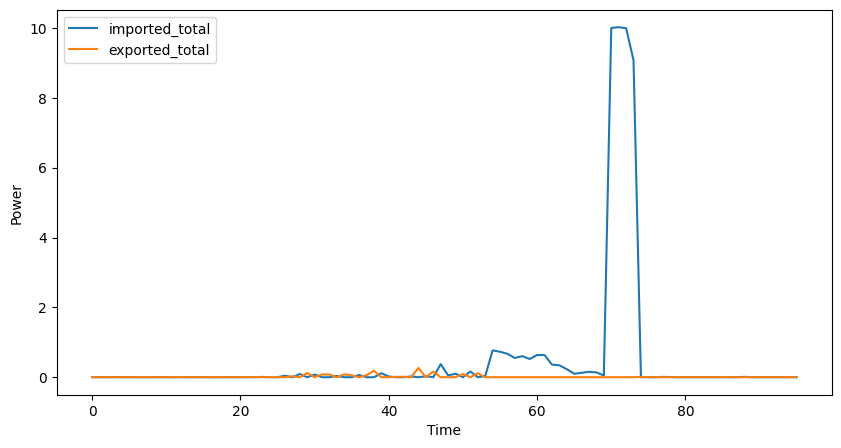

In [10]:
bat_discharge = eos_bat_schedule['discharge_good (kW)']
bat_charge = eos_bat_schedule['charge_good (kW)']
ev_charge = eos_ev_schedule['charge_bad (kW)']

cost, imported, exported = calculate_cost(bat_discharge=bat_discharge,
                                          bat_charge=bat_charge,
                                          ev_charge=ev_charge)

imported.plot(figsize=(10,5))
exported.plot(figsize=(10,5))
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.ylabel('Power')

print('Cost:', cost)

### Co-Optimized Apps

The combined case is the same, but it is important to note that the ev_charge_schedule was included as part of the load curve in the optimization. Since it is a fixed schedule, we can also just simply take it out, since the real load will be used anyways.

We use the case of a co-optimized environment with a Battery App with good forecasts and an EV app with bad forecasts.

Cost: 2.909081272826833


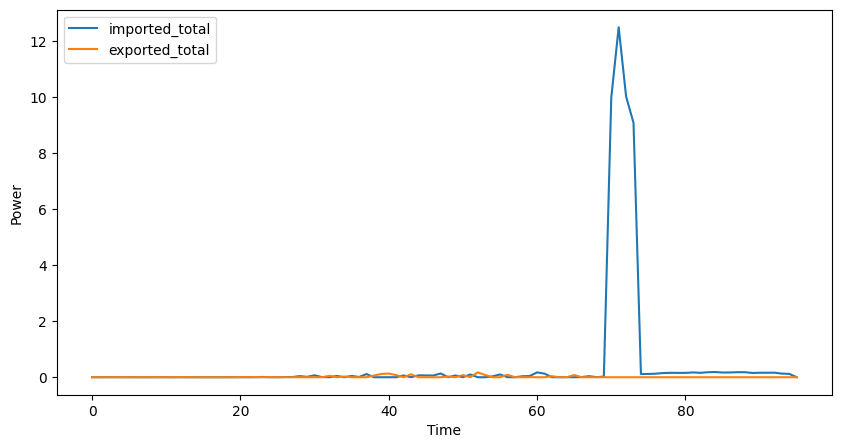

In [11]:
bat_discharge = eos_bat_schedule['discharge_good_with_ev (kW)']
bat_charge = eos_bat_schedule['charge_good_with_ev (kW)']
ev_charge = eos_ev_schedule['charge_good (kW)']

cost, imported, exported = calculate_cost(bat_discharge=bat_discharge,
                                          bat_charge=bat_charge,
                                          ev_charge=ev_charge)

imported.plot(figsize=(10,5))
exported.plot(figsize=(10,5))
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.ylabel('Power')

print('Cost:', cost)

## Scenarios

We can now analyze all interesting scenarios, and compare their prices and grid interactions.

In [12]:
cases = {}

### 1. Separate Battery (good forecast) + EV (bad forecast)
    - EV optimization w/ bad load, bad pv.
    - Battery optimization w/ good load, good pv.

This represents the current state of the art, with multiple different systems, with no connectivity and varying in forecasting ability.

Cost: 2.9482823571155268


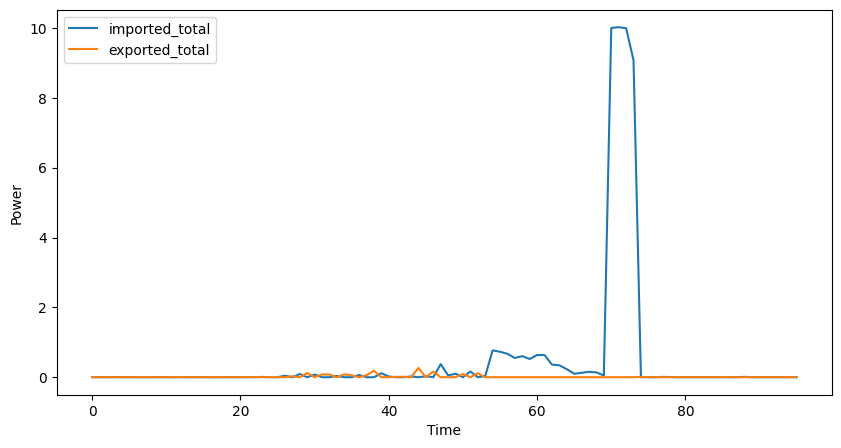

In [13]:
bat_discharge = eos_bat_schedule['discharge_good (kW)']
bat_charge = eos_bat_schedule['charge_good (kW)']
ev_charge = eos_ev_schedule['charge_bad (kW)']

cost, imported, exported = calculate_cost(bat_discharge=bat_discharge,
                                          bat_charge=bat_charge,
                                          ev_charge=ev_charge)
cases[1] = (cost, imported, exported, bat_discharge, bat_charge, ev_charge)

imported.plot(figsize=(10,5))
exported.plot(figsize=(10,5))
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.ylabel('Power')

print('Cost:', cost)

### 2. Separate and Perfect Forecasts
    - EV optimization w/ real load, real pv.
    - Battery optimization w/ real load, real pv.

This represents the maximum potential of the state of the art. This is the case in which both the EV and the Battery have access to perfect forecasts, but each optimizes individually, with their limited view of the environment.

Cost: 2.8865128483744877


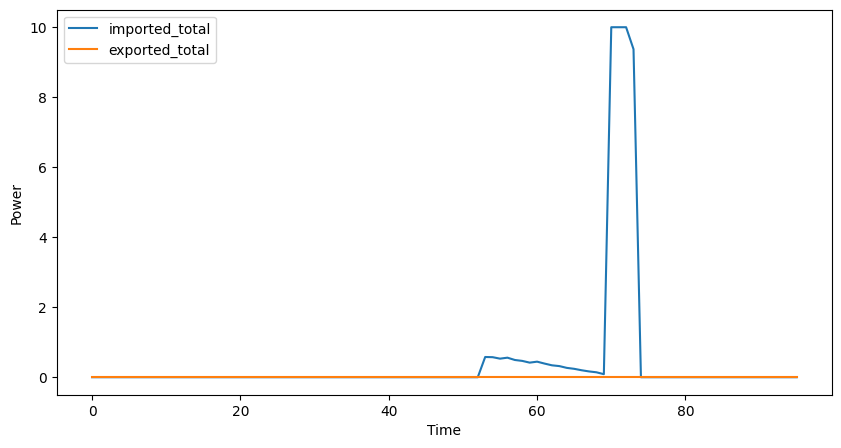

In [14]:
bat_discharge = eos_bat_schedule['discharge_real (kW)']
bat_charge = eos_bat_schedule['charge_real (kW)']
ev_charge = eos_ev_schedule['charge_real (kW)']

cost, imported, exported = calculate_cost(bat_discharge=bat_discharge,
                                           bat_charge=bat_charge,
                                           ev_charge=ev_charge)
cases[2] = (cost, imported, exported, bat_discharge, bat_charge, ev_charge)

imported.plot(figsize=(10,5))
exported.plot(figsize=(10,5))
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.ylabel('Power')

print('Cost:', cost)

### 3. Separate Battery (good forecast) + EV (good forecast)
    - EV optimization w/ good load, goo\d pv.
    - Battery optimization w/ good load, good pv.

This represents a one-sided benefit of EnergyOS, in which the EV App benefits from the good forecasts of the Battery App.

Cost: 2.926817538324714


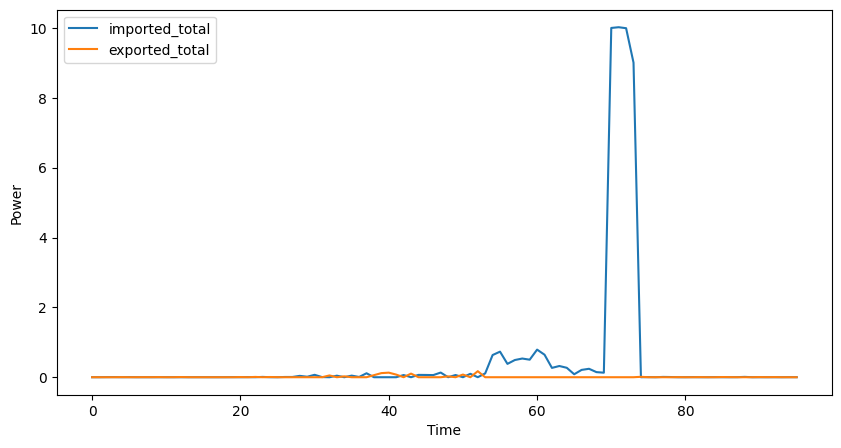

In [15]:
bat_discharge = eos_bat_schedule['discharge_good (kW)']
bat_charge = eos_bat_schedule['charge_good (kW)']
ev_charge = eos_ev_schedule['charge_good (kW)']

cost, imported, exported = calculate_cost(bat_discharge=bat_discharge,
                                          bat_charge=bat_charge,
                                          ev_charge=ev_charge)
cases[3] = (cost, imported, exported, bat_discharge, bat_charge, ev_charge)

imported.plot(figsize=(10,5))
exported.plot(figsize=(10,5))
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.ylabel('Power')

print('Cost:', cost)

### 4. Co-optimized Battery (good forecast) + EV (good forecast)
    - EV optimization w/ good load, good pv.
    - Battery optimization w/ good load + ev load, and good pv.

This represents a mutual benefit by using EnergyOS, in which the EV App benefits from the good forecasts of the Battery App, while the Battery App benefits by being able to use the EV schedule as part of its schedule generation.

Cost: 2.909081272826833


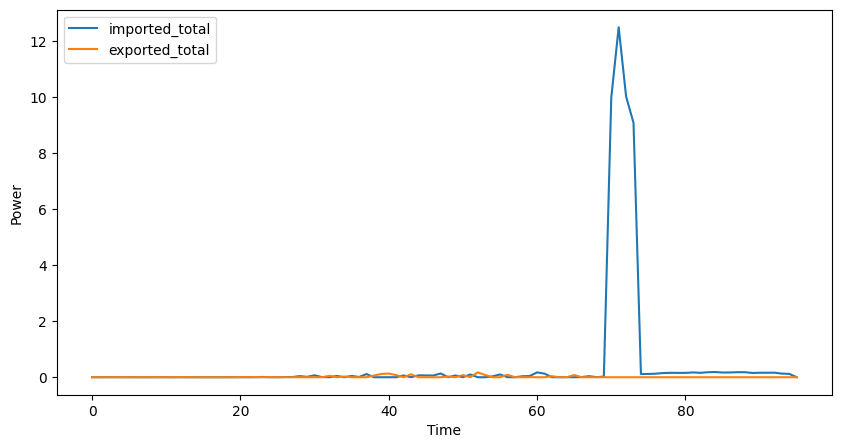

In [16]:
bat_discharge = eos_bat_schedule['discharge_good_with_ev (kW)']
bat_charge = eos_bat_schedule['charge_good_with_ev (kW)']
ev_charge = eos_ev_schedule['charge_good (kW)']

cost, imported, exported = calculate_cost(bat_discharge=bat_discharge,
                                          bat_charge=bat_charge,
                                          ev_charge=ev_charge)
cases[4] = (cost, imported, exported, bat_discharge, bat_charge, ev_charge)

imported.plot(figsize=(10,5))
exported.plot(figsize=(10,5))
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.ylabel('Power')

print('Cost:', cost)

### 5. Co-optimized and Perfect Forecasts
    - EV optimization w/ real load, real pv.
    - Battery optimization w/ real load + ev load, and real pv.

This represents the ground truth. This is the case in which both the EV and the Battery have access to perfect forecasts, and the Battery can use the EV's information for its own schedule. This is possible with EnergyOS if any of the participating apps have this forecasting ability.

Cost: 2.8584779646429856


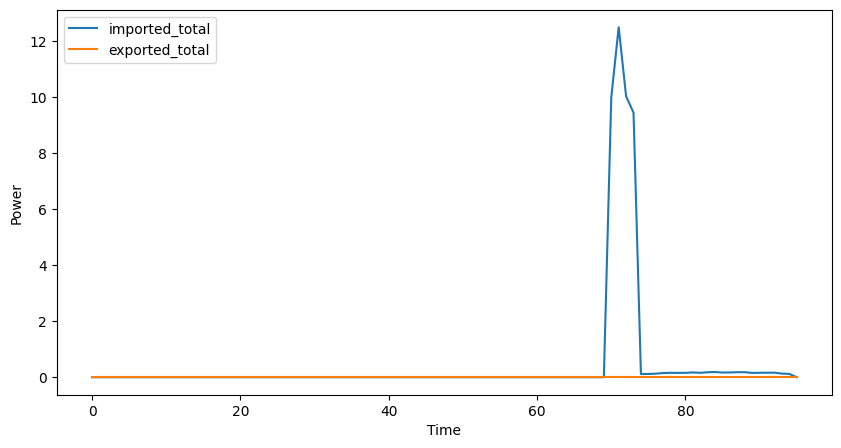

In [17]:
bat_discharge = eos_bat_schedule['discharge_real_with_ev (kW)']
bat_charge = eos_bat_schedule['charge_real_with_ev (kW)']
ev_charge = eos_ev_schedule['charge_real (kW)']

cost, imported, exported = calculate_cost(bat_discharge=bat_discharge,
                                           bat_charge=bat_charge,
                                           ev_charge=ev_charge)
cases[5] = (cost, imported, exported, bat_discharge, bat_charge, ev_charge)

imported.plot(figsize=(10,5))
exported.plot(figsize=(10,5))
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.ylabel('Power')

print('Cost:', cost)

### Compare Costs

[2.9482823571155268, 2.8865128483744877, 2.926817538324714, 2.909081272826833, 2.8584779646429856]


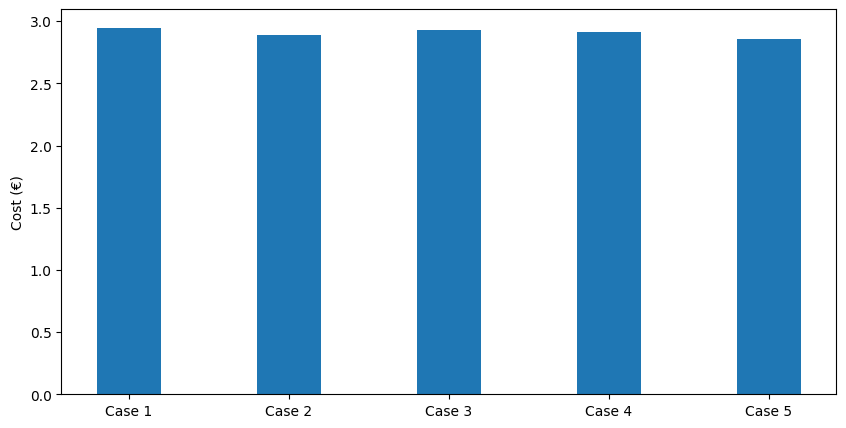

In [18]:
case_nums = list(range(1, len(cases) + 1))
names = ['Case {}'.format(i) for i in case_nums]
costs = [cases[i][0] for i in case_nums]
print(costs)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(names, costs, width = 0.4)
 
# plt.xlabel("Courses offered")
plt.ylabel("Cost (€)")
# plt.title("Students enrolled in different courses")
plt.show()

In [19]:
SOTA = costs[0]

for i in range(0,5):
    print('Cost savings(%) from SOTA case {}:'.format(i+1), (abs(costs[i] - SOTA)/costs[0])*100)

Cost savings(%) from SOTA case 1: 0.0
Cost savings(%) from SOTA case 2: 2.0951015289279034
Cost savings(%) from SOTA case 3: 0.7280448814208255
Cost savings(%) from SOTA case 4: 1.3296244911578377
Cost savings(%) from SOTA case 5: 3.0459902273540007


## Schedule Comparisons

We now compare the two device schedules for various scenarios and observe the shifts in charge and discharge times. This relies on the previous section.

In [24]:
def format_name(name, device):
    assert device == 'bat' or device == 'ev'

    name, unit = name.split(' ')
    pieces = name.split('_')
    label_name = '{}_{}_forecast'.format(device, '_'.join(pieces[0:2]))
    if len(pieces) > 2:
        label_name = label_name + '_' + '_'.join(pieces[2:])
    return '{} {}'.format(label_name, unit)


def compare_cases(case_nums):
    assert len(case_nums) == 2, 'Only compare two cases at a time'
    comparisons = [cases[i] for i in case_nums]
    x = eos_forecasts.index
    fig, axs = plt.subplots(len(comparisons)*2, 2, figsize=(15,5*len(comparisons)), sharex=True)
    for i, case in enumerate(comparisons):
        i*=2
        (_, imported, exported, bat_discharge, bat_charge, ev_charge) = case
        for k in range(2):
            i = i + k
            axs[i, 0].plot(bat_discharge, label=format_name(bat_discharge.name, 'bat'))
            axs[i, 0].plot(bat_charge, label=format_name(bat_charge.name, 'bat'))
            axs[i, 0].plot(ev_charge, label=format_name(ev_charge.name, 'ev'))
            axs[i, 0].plot(eos_forecasts['solar_real (kW)'], label='solar_real (kW)')
            axs[i, 0].plot(eos_forecasts['load_real (kW)'], label='load_real (kW)')
            axs[i, 1].plot(imported, label=imported.name)
            axs[i, 1].plot(exported, label=exported.name)

            d = .01  # how big to make the diagonal lines in axes coordinates
            for j in range(2):
                if k == 0:
                    ax = axs[i, j]
                    ax.set_ylim(bottom=9)  # outliers only
                    ax.spines['bottom'].set_visible(False)
                    ax.xaxis.tick_top()
                    ax.tick_params(labeltop='off')  # don't put tick labels at the top
    
                    kwargs = dict(transform=ax.transAxes, clip_on=False)
                    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
                    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
                else:
                    ax2 = axs[i, j]
                    ax2.set_ylim(bottom=0, top=2.5)  # most of the data
                    ax2.spines['top'].set_visible(False)
                    ax2.xaxis.tick_bottom()

                    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
                    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
                    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    for i in range(len(comparisons)):
        i*=4
        for ax in axs.flat[i:i+2]:
            ax.legend(loc="upper left") 

    fig.supxlabel('Timestep', fontsize=14, y=0.06)
    fig.supylabel('Power (kW)', fontsize=14, x=0.06)
    fig.suptitle('Case {} (above) vs Case {} (below)'.format(*case_nums), fontsize=16, y=0.95)
    plt.savefig('HH_AnalysisCases_{}.pdf'.format('_'.join(map(str, case_nums))), dpi=600)

Case 1 vs Case 3: Benefit of Resource sharing via EnergyOS

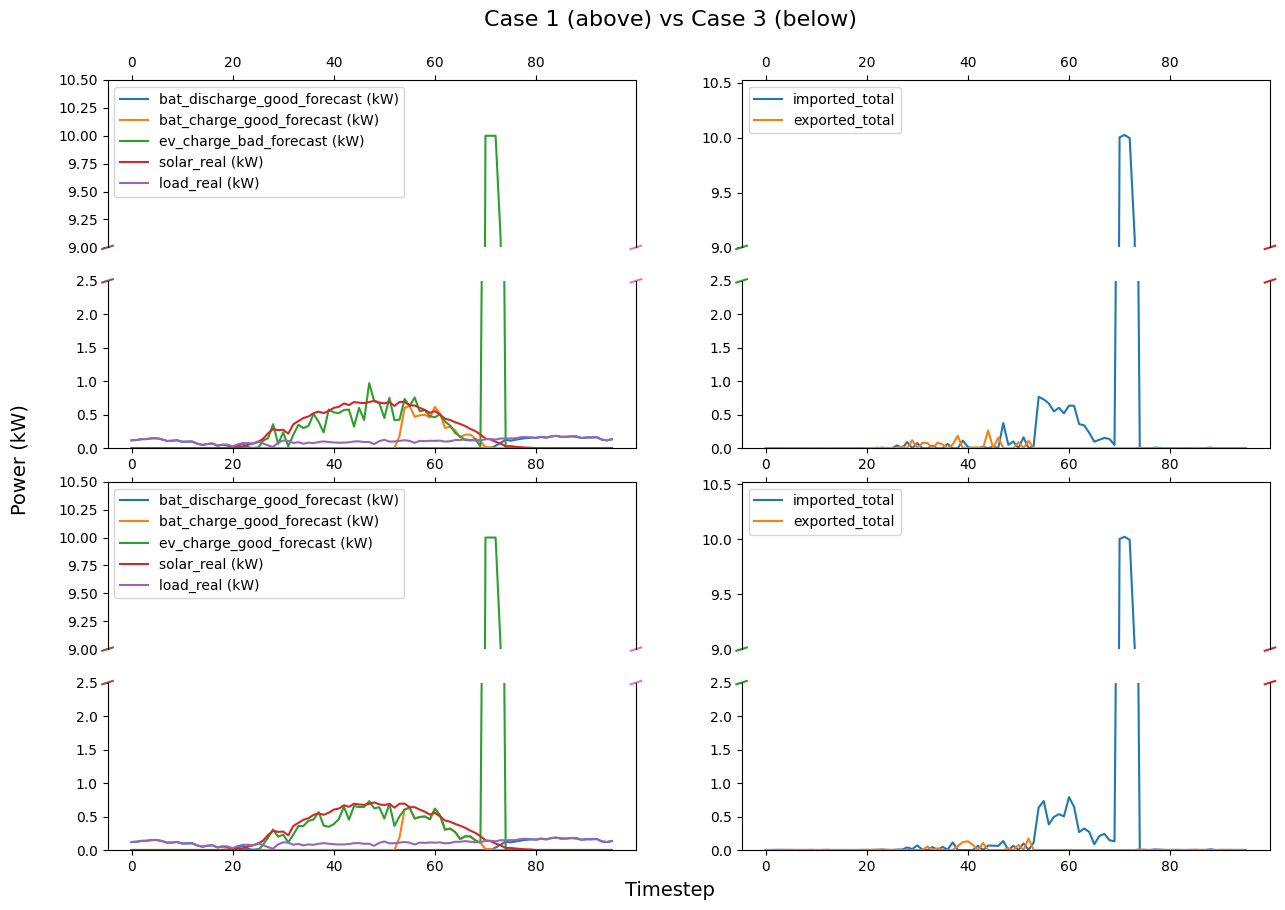

In [25]:
case_nums = [1, 3]
compare_cases(case_nums)

Case 3 vs Case 4: Benefit of Co-optimization using EnergyOS

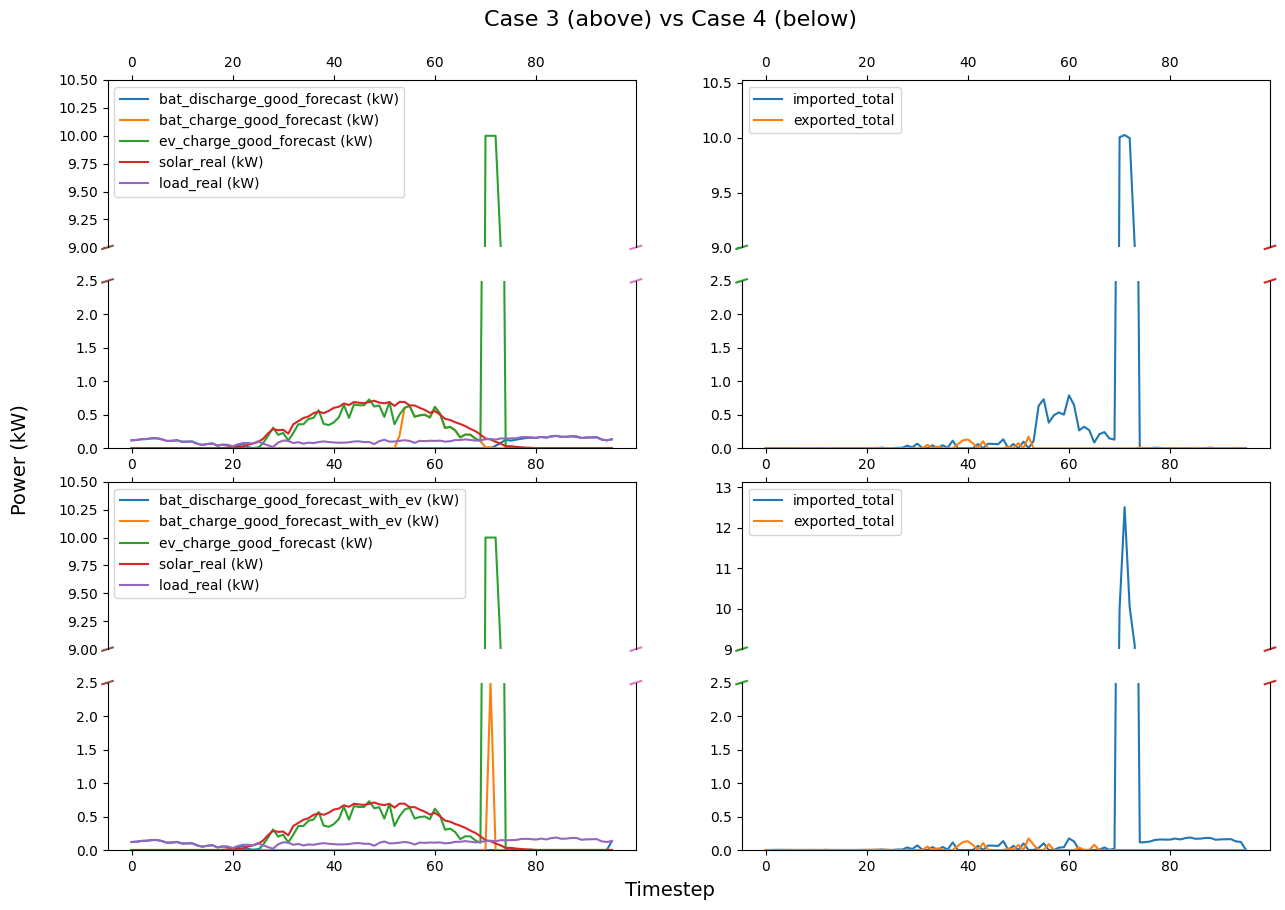

In [26]:
case_nums = [3, 4]
compare_cases(case_nums)

Case 2 vs Case 5: Theoretical limit of SOTA vs with EnergyOS

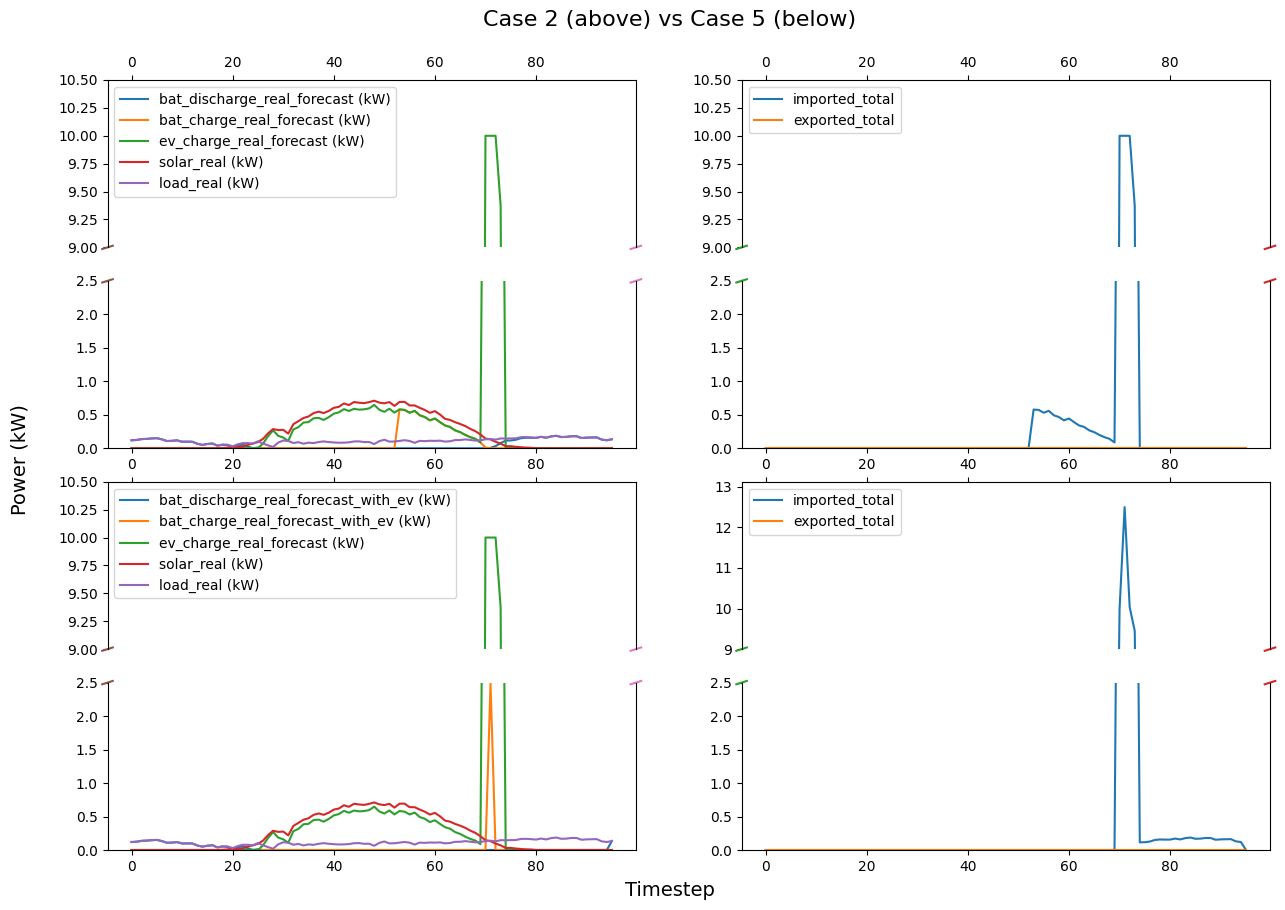

In [27]:
case_nums = [2, 5]
compare_cases(case_nums)

## Live Simulation Data

We can now even run our EOS example using this data. We use scenario #3 for this. Run the following code to change the simulations data, then refer to the example's README.md for how to run it.

In [157]:
bat_discharge = eos_bat_schedule['discharge_good_with_ev (kW)']
bat_charge = eos_bat_schedule['charge_good_with_ev (kW)']
ev_charge = eos_ev_schedule['charge_good (kW)']

# Make the csvs for the simulations.
bat_schedule_sim = pd.DataFrame()
bat_schedule_sim['kW (charge-,discharge+)'] = bat_discharge - bat_charge
bat_schedule_sim.to_csv('battery_app/battery_schedule.csv')
ev_schedule_sim = pd.DataFrame()
ev_schedule_sim['kW'] = ev_charge
ev_schedule_sim.to_csv('electric_vehicle_app/ev_schedule.csv')

# Only the battery has the proper forecasts.
load_sim = pd.DataFrame()
load_sim['kW'] = eos_forecasts['load_good (kW)']
load_sim.to_csv('battery_app/load_forecast.csv')
solar_sim = pd.DataFrame()
solar_sim['kW'] = eos_forecasts['solar_good (kW)']
solar_sim.to_csv('battery_app/pv_forecast.csv')